In [1]:
import torch
import torch.nn as nn
from DATALOADER import baby_loader
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torchvision

In [2]:
train_path=r'D:\DL_DATA\ubfc_seg\Mix\train'
val_path=r'D:\DL_DATA\ubfc_seg\Mix\val'

In [3]:
train_data=baby_loader(train_path)
val_data=baby_loader(val_path)



In [4]:
train_loader=DataLoader(train_data,batch_size=32,shuffle=True,drop_last=True,num_workers=8)
val_loader=DataLoader(val_data,batch_size=32,drop_last=True,num_workers=8)

In [6]:
img,label=next(iter(train_loader))

In [7]:
img.shape,label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1, 224, 224]))

In [8]:
len(train_data),len(val_data)

(6700, 2320)

In [ ]:
model=torchvision.models.vgg13(weights=torchvision.models.VGG13_Weights)
alexnet=nn.Sequential(*list(model.children())[0])
ypred=alexnet(img)

In [5]:
class decoder_seg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.conv4=nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.conv5=nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.conv6=nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.conv7=nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.conv8=nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.conv9=nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.conv10=nn.Conv2d(64,4,kernel_size=3,padding=1)
        self.relu=nn.ReLU()

    def forward(self,x):
        x=F.interpolate(x, scale_factor=2)
        x=self.relu(self.conv1(x))
        x=self.relu(self.conv2(x))
        x=F.interpolate(x,scale_factor=2)
        x=self.relu(self.conv3(x))
        x=self.relu(self.conv4(x))
        x=F.interpolate(x,scale_factor=2)
        x=self.relu(self.conv5(x))
        x=self.relu(self.conv6(x))
        x=F.interpolate(x,scale_factor=2)
        x=self.relu(self.conv7(x))
        x=self.relu(self.conv8(x))
        x=F.interpolate(x,scale_factor=2)
        x=self.relu(self.conv9(x))
        x=self.conv10(x)
        
        return x
    

In [6]:
class Baby_skin(pl.LightningModule):
    def __init__(self):
        super().__init__()
        model=torchvision.models.vgg13(weights=torchvision.models.VGG13_Weights)
        self.encoder_seg=nn.Sequential(*list(model.children())[0])
        self.decoder_seg=decoder_seg()
        self.loss_fun=nn.CrossEntropyLoss()
        self.optimizer=torch.optim.Adam(self.decoder_seg.parameters(),lr=1e-4)
        
    def forward(self,x):
        x=self.encoder_seg(x)
        x=self.decoder_seg(x)
        return x
    def training_step(self,batch,batch_index):
        img,mask=batch
        pred=self(img)
        mask=mask[:,0,:,:]
        
        loss=self.loss_fun(pred,mask)
        pred=torch.argmax(pred,dim=1)
        
        train_acc=(pred==mask).sum()/(mask.numel())
        
        self.log('Training_loss',loss)
        self.log('Training_acc',train_acc)
        return loss
        
    def validation_step(self,batch,batch_indx):
        img,mask=batch
        pred=self(img)
        mask=mask[:,0,:,:]
        
        loss=self.loss_fun(pred,mask)
        
        pred=torch.argmax(pred,dim=1)
        
        val_acc=(pred==mask).sum()/(mask.numel())
        
        self.log('Validation_loss',loss)
        self.log('Val_acc',val_acc)
        return loss
    
    def configure_optimizers(self):
        return [self.optimizer]

In [7]:
model_check=ModelCheckpoint(monitor='Val_acc',save_top_k=2,mode='max')

In [8]:
model=Baby_skin()


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
trainer=pl.Trainer(accelerator='auto',logger=TensorBoardLogger(save_dir='./logs'),callbacks=model_check,
                                                              max_epochs=100,log_every_n_steps=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model,train_loader,val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | encoder_seg | Sequential       | 9.4 M 
1 | decoder_seg | decoder_seg      | 9.4 M 
2 | loss_fun    | CrossEntropyLoss | 0     
-------------------------------------------------
18.8 M    Trainable params
0         Non-trainable params
18.8 M    Total params
75.240    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\PhysioSens\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\PhysioSens\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

C:\Users\PhysioSens\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [7]:
model=Baby_skin.load_from_checkpoint(r'C:\Users\PhysioSens\Desktop\python-jupyter\ubfc_seg\mix\logs\lightning_logs\version_9\checkpoints\epoch=72-step=16352.ckpt')
model=model.to('cuda')
model=model.eval()

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
mask.shape,mask.size

((224, 224), 50176)

0.9972496811224489
0.9958147321428571
0.9975087691326531
0.9932637117346939
0.9947385204081632


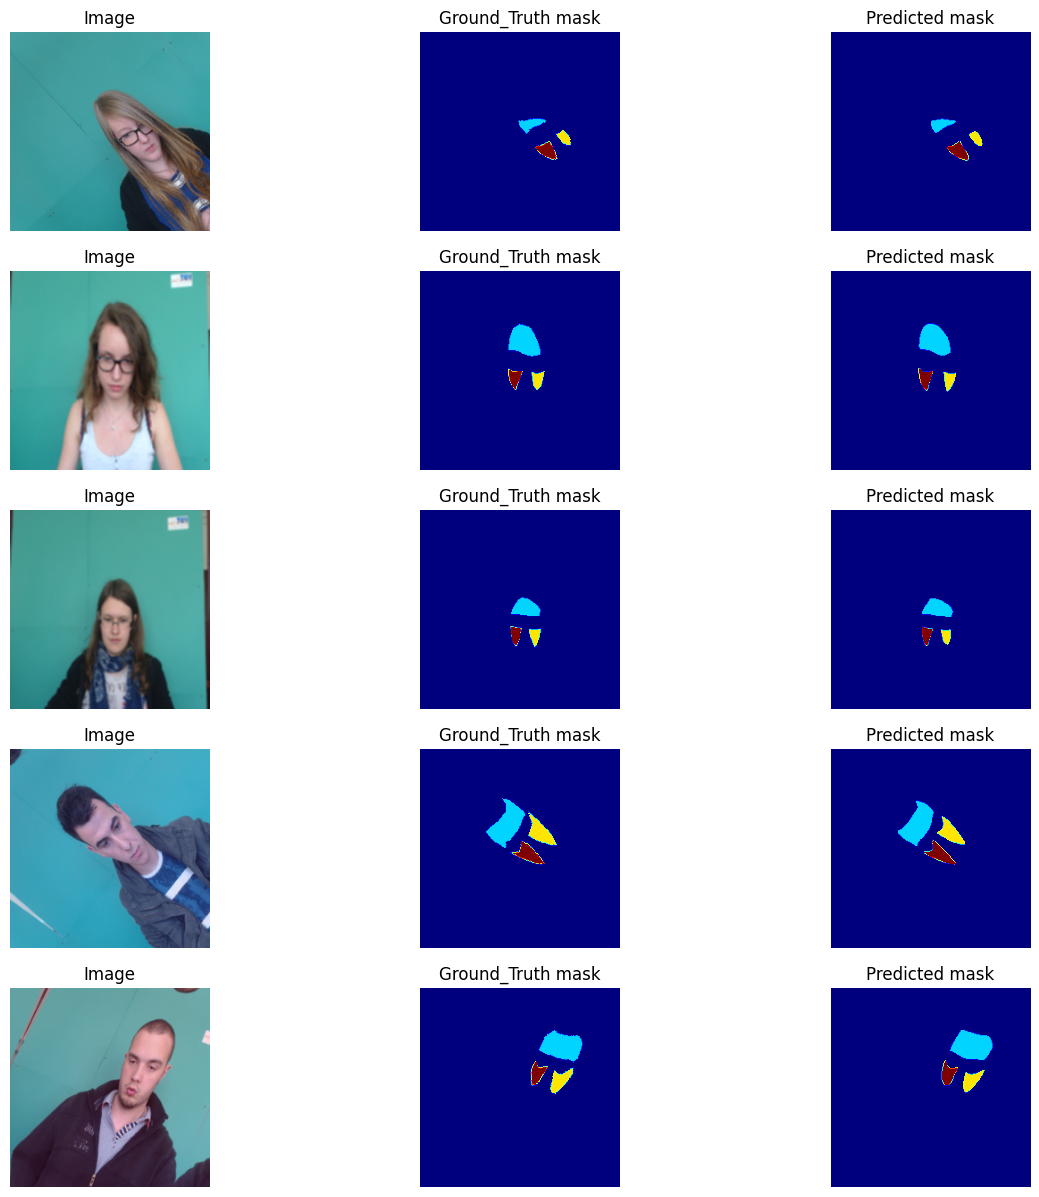

In [18]:
fig,axs=plt.subplots(5,3,figsize=(15,15))
for i in range(5):
    num=np.random.choice(len(val_data))
    img,mask=val_data[num]
    img=img.unsqueeze(0)
    img=img.to('cuda')
    with torch.no_grad():
        ypred=model(img)
    img=img.cpu().detach().numpy()
    mask=mask[0,:,:].cpu().detach().numpy()
    
    img=np.transpose(img[0],(1,2,0))
    axs[i][0].imshow(img[:,:,::-1])
    axs[i][0].set_title('Image')
    axs[i][0].axis('off')
    
    axs[i][1].imshow(mask,cmap='jet')
    axs[i][1].set_title('Ground_Truth mask')
    axs[i][1].axis('off')
    
    ypred=torch.argmax(ypred,dim=1).cpu().detach().numpy()
    
    axs[i][2].imshow(ypred[0],cmap='jet')
    axs[i][2].set_title('Predicted mask')
    axs[i][2].axis('off')
    
    print(np.sum(mask==ypred[0])/(mask.size))
    
plt.axis('off')
plt.show()

In [19]:
import numpy as np

def dice_coefficient(y_true, y_pred, class_label):
    # Create binary masks for the specific class
    y_true_class = (y_true == class_label).astype(np.int32)
    y_pred_class = (y_pred == class_label).astype(np.int32)

    intersection = np.sum(y_true_class * y_pred_class)
    sum_ = np.sum(y_true_class) + np.sum(y_pred_class)

    if sum_ == 0:  # Handle the case where both masks are empty
        return 1.0

    dice = 2.0 * intersection / sum_
    return dice

def mean_dice_coefficient(y_true, y_pred, num_classes):
    dice_scores = []
    for c in range(num_classes):
        dice = dice_coefficient(y_true, y_pred, c)
        dice_scores.append(dice)
    return np.mean(dice_scores)

In [20]:
accu=[]
dice=[]
for img,mask in val_data:
    img=img.unsqueeze(0)
    img=img.to('cuda')
    with torch.no_grad():
        ypred=model(img)
    img=img.cpu().detach().numpy()
    mask=mask[0,:,:].cpu().detach().numpy()
    ypred=torch.argmax(ypred,dim=1).cpu().detach().numpy()
    dice.append(mean_dice_coefficient(mask,ypred[0],4))
    accu.append(np.sum(mask==ypred[0])/(mask.size))
np.average(accu)
np.average(dice)

0.9079780054405484

In [12]:
np.unique(ypred),np.unique(mask)

(array([0, 1, 2], dtype=int64), array([0, 1, 2], dtype=int64))

In [35]:
img_view=np.uint8(ypred[0]*40)
cv2.imshow('frame',img_view)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
cv2.destroyAllWindows()

In [34]:
ypred

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int64)

In [33]:
x=np.array([[1,2,3],[1,2,5],[7,8,1]])
x[x==1]

array([1, 1, 1])